In [2]:
import os 
os.chdir("/u/phg/adas")
%matplotlib inline
import matplotlib
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

import atomdat.adas.adf11 as adf11
import atomdat.adas.adf13 as adf13
import atomdat.adas.adf15 as adf15

In [3]:
%matplotlib notebook
import atomdat.adas.ibal_phg as ibal; reload(ibal)
plt.close("all")

In [19]:
import atomdat.adas.ibal_phg as ibal
import scipy.interpolate as spi
import scipy.linalg as scl

def phg_calc_fz(elem, nt=int(1.E2),  # nt = num of points
        ne=None, # electron density
        te=None, # and electron temperature vlaue arrays
        s=None, taus=0.,taua=0.,  # different source terms
        n0=0.,l0=0.1,e0=0.2, # neutral density paramteters 
        fplt=False,
        debug=False,
        fsilent=False):
    '''
    #Transport loss terms 
    ta - to hotter regions
    ts - to colder regions
    s  - source term
    '''

    pn = '/u/phg/adas/adf11/'
    year = ["96"]*5

    fns = 'scd'+year[0]+'/scd'+year[0]+'_'+elem+'.dat'; scd = adf11.ADF11(fns,pn=pn)
    fna = 'acd'+year[1]+'/acd'+year[1]+'_'+elem+'.dat'; acd = adf11.ADF11(fna,pn=pn)
    fnc = 'ccd'+year[2]+'/ccd'+year[2]+'_'+elem+'.dat'; ccd = adf11.ADF11(fnc,pn=pn)
    fnt = 'plt'+year[3]+'/plt'+year[3]+'_'+elem+'.dat'; prt = adf11.ADF11(fnt,pn=pn)
    fnb = 'prb'+year[4]+'/prb'+year[4]+'_'+elem+'.dat'; prb = adf11.ADF11(fnb,pn=pn)

  
    #Provide temperatures & densities
    nz = acd.dat.nz
    if te is None:
        ter = [acd.dat.te.min(),acd.dat.te.max()]
        te  = np.logspace(ter[0],ter[1],nt)
    nt = te.shape[0]

    if ne is None:
        ne = np.ones(te.shape)*1E17
        print('Assume coronal equilibrium (1E17 m-3)')
    if type(ne) is float:
        ne = np.ones(te.shape)*ne

    #Provide neutral densities for CX
    if type(n0) != int and type(n0) != float:
        ...
    elif n0 > 0.:
        n0l = np.exp(-te**e0/l0)
        n0 = n0*n0l/n0l.max()
    else:
        n0 = n0l = np.zeros(nt)


    #Provide source terms
    if s is None:
        s = np.array([0. for i in range(nt)])

    fz = np.zeros((nt,nz+1))
    lz  = np.zeros((nt,nz+1))
    lzl = np.zeros((nt,nz+1))

    m = ibal.make_transition_matrix(acd,scd,ccd,ne,te,n0,taus,taua,fsilent=fsilent)

    for i in range(nt):
        tmp = m[:,:,i]
        #Normalize matrix
        #norm = tmp.max()
        #tmp = tmp/norm
        #s = s/norm

        #Solve kernel for fractional abundance
        z = np.abs(scl.null_space(tmp))
        if z.shape[1] > 1: z = z[:,0]
        z = np.squeeze(z)
        #Normalize fractional abundance (Why did this not work with matrix?)
        fz[i,:] = z/z.sum()
        #x = np.linalg.solve(m,s)


    #Determine Lz function
    for j in range(nz):
        interpol_prt = prt.interpolate(ne,te,j,silent=fsilent)*fz[:,j]
        lzl[:,j] = interpol_prt
        lz[:,j]  = interpol_prt
        lz[:,j] += prb.interpolate(ne,te,j,silent=fsilent)*fz[:,j]

    #Total radiative power function
    lz[:,-1] = np.sum(lz,1)
    lzl[:,-1] = np.sum(lzl,1)
    
    if fplt:
        if n0[0] > 0.:
            fig, ax = plt.subplots()
            ax.plot(te,n0)
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_ylabel('n$_0$ [m-3]')
            ax.set_xlabel('T$_e$ [eV]')
            ax.set_ylim((1.E10,1.E21))
            plt.show(block=False)
            
    return te, fz, lz, lzl

lcol = ['k','b','g','y','orange','r','violet','brown','gray']
import utils.colors as colors; reload(colors); clrs = colors.clrs()
def phg_plot_fz(te, fz, fig=None, ax=None, labels=None, **kwargs):
    nz = fz.shape[1] # ionisations
    if fig is None:
        fig = plt.figure()
    if ax is None: 
        ax = fig.gca()

    col = clrs.resetnull()
    for i in range(nz):
        if i == 4 or i == 6:
            clrs.next()
        if i == 5:
            col = clrs.resetnull()
            [clrs.next() for i in range(4)]
            
        label = labels[i] if labels is not None else None
        ax.plot(te,fz[:,i],c=clrs.next(), label=label, **kwargs)
        #ax.plot(te,fz[:,i],c=lcol[i], label=label, **kwargs)
    
    ax.set_xlabel('T$_e$ [eV]')
    ax.set_ylabel('f$_A$')
    ax.set_xscale('log')
    
    if labels is not None:
        ax.legend()
    return fig

<IPython.core.display.Javascript object>


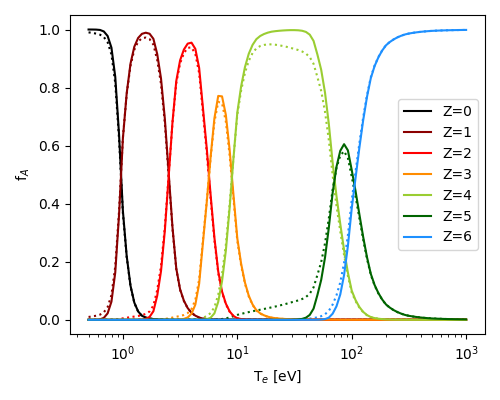

In [21]:
fig, ax = plt.subplots(figsize=(5,4))

N = 100
te = np.logspace(np.log10(5e-1),np.log10(1e3),N)
labels = [f"Z={i}" for i in range(10)]

ne = np.ones(N)*1E20
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0.1)
_ = phg_plot_fz(te, fz, fig=fig, ax=ax, ls=":")

ne = np.ones(N)*1E20
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne)
_ = phg_plot_fz(te, fz, fig=fig, ax=ax, labels=labels)

# ne = np.ones(N)*6E13
# _,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taua=10000)
# _ = phg_plot_fz(te, fz, fig=fig, ax=ax, ls="--")

fig.tight_layout()